In [2]:


import pandas as pd
import sqlite3

import os
from IPython.display import display
import matplotlib.pyplot as plt

from src.dataprep.helpers.functions import *
from src.dataprep.helpers.variables import *

In [49]:

q = """select grantid
            , Award_AwardEffectiveDate
            , AwardInstrument_Value
            , Award_AwardAmount
            , CAST(SUBSTR(Award_AwardEffectiveDate, 7, 4) AS INT) AS Year
            , Organization_Directorate_ShortName
            , Organization_Division_ShortName
        from NSF_MAIN
    """

with sqlite3.connect(db_file) as con:
    d_main = pd.read_sql(sql = q, con = con)


d_main.head()

,GrantID,Award_AwardEffectiveDate,AwardInstrument_Value,Award_AwardAmount,Year,Organization_Directorate_ShortName,Organization_Division_ShortName
0,2200023,04/01/2022,standard grant,49998.0,2022,GEOSCIENCES,ICER
1,2200033,10/01/2021,standard grant,50665.0,2021,BIOLOGICAL SCIENCES,INTEGRATIVE ORGANISMAL SYSTEMS
2,2200040,05/01/2022,standard grant,404662.0,2022,MATHEMATICAL & PHYSICAL SCIEN,CHEMISTRY
3,2200042,10/01/2021,standard grant,238545.0,2021,COMPUTER & INFO SCIE & ENGINR,COMPUTER AND NETWORK SYSTEMS
4,2200058,04/15/2022,cooperative agreement,999999.0,2022,"TECH, INNOVATION, & PARTNERSHIPS",TRANSLATIONAL IMPACTS


Aggregates by year and award instrument

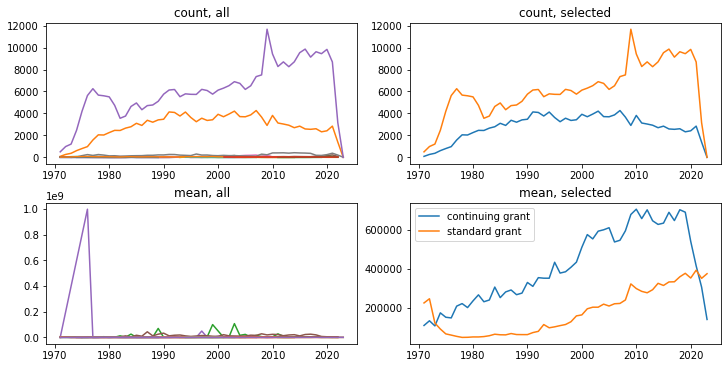

In [87]:
agg_instr = (d_main.groupby(["Year", "AwardInstrument_Value"])
                .agg({"Award_AwardAmount": ["sum", "count", "mean"]})
                .stack(0)
                )


fig, axs = plt.subplots(2, 2, figsize=(10, 5), layout='constrained')


award_types = ["standard grant", "continuing grant"] # these seem to be the main award_types
stats_to_plot = ["count", "mean"]

for i in range(len(stats_to_plot)):
    stat = stats_to_plot[i]
    for label, df in agg_instr.groupby('AwardInstrument_Value'):
        df = df.reset_index()
        df = df.loc[df["Year"] > 1970,:]
        axs[i, 0].plot(df["Year"], df[stat], label = label)
        axs[i, 0].set_title(f"{stat}, all")
        if label in award_types:
            axs[i, 1].plot(df["Year"], df[stat], label = label)
            axs[i, 1].set_title(f"{stat}, selected")

plt.legend()
plt.show()


Aggregates for selected by year and directorate

In [86]:
d_main.Organization_Directorate_ShortName.unique()

array(['GEOSCIENCES', 'BIOLOGICAL SCIENCES',
       'MATHEMATICAL & PHYSICAL SCIEN', 'COMPUTER & INFO SCIE & ENGINR',
       'TECH, INNOVATION, & PARTNERSHIPS', 'ENGINEERING',
       'EDUCATION AND HUMAN RESOURCES', 'THE DIRECTOR',
       'SOCIAL, BEHAV & ECONOMIC SCIE', 'INFORMATION & RESOURCE MGMT',
       None, 'BUDGET, FINANCE, & AWARD MANAGEMENT',
       'NATIONAL COORDINATION OFFICE',
       'NATL NANOTECHNOLOGY COORDINATING OFFICE', 'POLAR PROGRAMS',
       'SOCIAL, BEHAVIORAL & ECONOMIC SCIENCES',
       'MATHEMATICAL & PHYSICAL SCIENCES',
       'COMPUTER & INFORMATION SCIENCE & ENGINEERING',
       'EDUCATION & HUMAN RESOURCES'], dtype=object)

In [105]:
main_fields = ["GEOSCIENCES", "BIOLOGICAL SCIENCES", "MATHEMATICAL & PHYSICAL SCIEN",
                  "COMPUTER & INFO SCIE & ENGINR", "ENGINEERING", "SOCIAL, BEHAV & ECONOMIC SCIE"]

# there are some more, maybe they are not current anymore? (as they are not in NSF_MAG_matched.xlsx from Jack?)
other_fields = ["SOCIAL, BEHAVIORAL & ECONOMIC SCIENCES", "COMPUTER & INFORMATION SCIENCE & ENGINEERING",
                "MATHEMATICAL & PHYSICAL SCIENCES", "INFORMATION & RESOURCE MGMT"]
fields = main_fields + other_fields

mask = (d_main["AwardInstrument_Value"].isin(award_types)
        & d_main["Organization_Directorate_ShortName"].isin(fields))
agg_fld = (d_main.loc[mask, :]
                .groupby(["Year", "Organization_Directorate_ShortName"])
                .agg({"Award_AwardAmount": ["sum", "count", "mean"]})
                .stack(0)
                )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


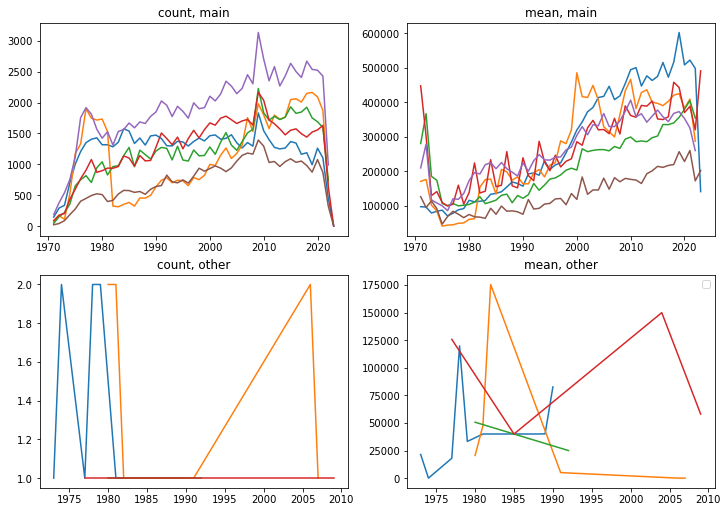

In [107]:
# show both main and all 

fig, axs = plt.subplots(2, 2, figsize=(10, 7), layout='constrained')

for i in range(len(stats_to_plot)):
    stat = stats_to_plot[i]
    for field, df in agg_fld.groupby('Organization_Directorate_ShortName'):
        df = df.reset_index()
        df = df.loc[df["Year"] > 1970,:]
        if field in main_fields: 
            axs[0, i].plot(df["Year"], df[stat])
            axs[0, i].set_title(f"{stat}, main")
        elif field in other_fields:
            axs[1, i].plot(df["Year"], df[stat])
            axs[1, i].set_title(f"{stat}, other")



plt.legend() # when do I use ax.legend and when plt.legend?
plt.show()

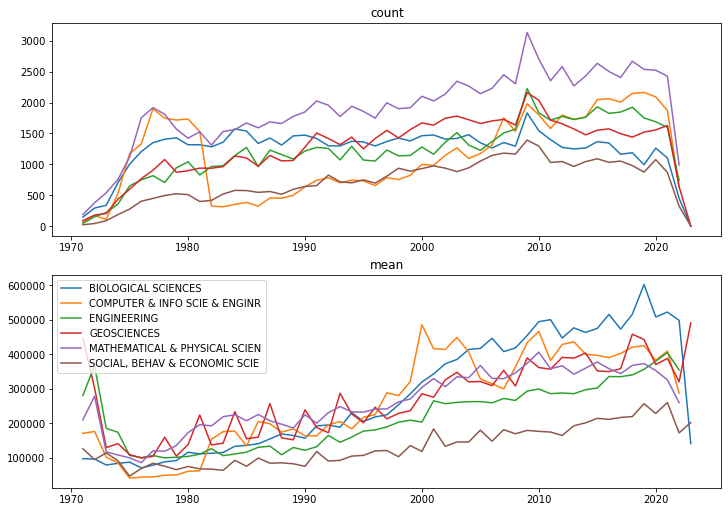

In [110]:
# show main with labels

fig, axs = plt.subplots(2, 1, figsize=(10, 7), layout='constrained')

for i in range(len(stats_to_plot)):
    stat = stats_to_plot[i]
    for field, df in agg_fld.groupby('Organization_Directorate_ShortName'):
        df = df.reset_index()
        df = df.loc[df["Year"] > 1970,:]
        if field in main_fields: 
            axs[i].plot(df["Year"], df[stat], label = field)
            axs[i].set_title(f"{stat}")



plt.legend() # when do I use ax.legend and when plt.legend?
plt.show()

### Summary: implications for linking
- Main idea: 
    - reduce noise
    - reduce redundant candidates -> search for matches should be easier
- NSF 
    - Keep only "standard grant" and "continuing grant"
    - Condition on major field. Ie if using "economics", filter grants by "Social, Behav & Economic Scie"
- At the moment, I am not using the year of the grant. How to use the year?
    - Unique tuples (year, institution) from MAG
    - Single publication year and institution. 
    - But: publication year is recorded with a lag compared to employment year. A problem?
